<a href="https://colab.research.google.com/github/dranzer120/ADS-tm-sentiment/blob/main/Assignment_6_Sentiment_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [57]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import csv
import sys
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [4]:
# Add any additional import statements you need here
# !pip install emoji
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
# change `data_location` to the location of the folder on your machine.
# data_location = "/users/rsadeghian/textmining/ads-tm-api-scrape/"

# These subfolders should still work if you correctly stored the
# data from the Module 1 assignment
# twitter_folder = "twitter/"
# lyrics_folder = "lyrics/"

positive_words_file = "/content/drive/MyDrive/Colab Notebooks/positive-words.txt"
negative_words_file = "/content/drive/MyDrive/Colab Notebooks/negative-words.txt"
tidy_text_file = "/content/drive/MyDrive/Colab Notebooks/tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well.

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist.




In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Read in the lyrics data

lyrics_folder = "/content/drive/MyDrive/Colab Notebooks/lyrics"

lyrics_data = defaultdict(dict)

for filename in os.listdir(lyrics_folder):
    if filename.endswith(".txt"):
        # Split at the first underscore to separate artist and song
        parts = filename.split("_", 1)
        if len(parts) == 2:
            artist, song_file = parts
            file_path = os.path.join(lyrics_folder, filename)
            with open(file_path, "r", encoding="utf-8") as f:
                lyrics_data[artist][song_file] = f.read()

In [22]:
# Read in the twitter data

twitter_folder = "/content/drive/MyDrive/Colab Notebooks/twitter"

twitter_descriptions = defaultdict(list)
csv.field_size_limit(sys.maxsize)

for file in os.listdir(twitter_folder):
    if file.endswith("_followers_data.txt"):
        artist = file.replace("_followers_data.txt", "")
        path = os.path.join(twitter_folder, file)
        with open(path, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f, delimiter="\t")
            for row in reader:
                desc = row.get("description")
                if isinstance(desc, str) and desc.strip():
                    twitter_descriptions[artist].append(desc.strip())

In [31]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a
# dictionary for this.

sentiment_dict = {}

# Read positive words
with open(positive_words_file, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line and not line.startswith(";"):
            sentiment_dict[line] = 1

# Read negative words
with open(negative_words_file, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line and not line.startswith(";"):
            sentiment_dict[line] = -1

In [32]:
tidy_df = pd.read_csv(tidy_text_file, sep="\t")
tidy_df["score"] = tidy_df["sentiment"].map({"positive": 1, "negative": -1})

In [34]:
sentiment_dict.update(dict(zip(tidy_df["word"], tidy_df["score"])))

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository.

After you have calculated these sentiments, answer the questions at the end of this section.


In [36]:
# your code here
song_sentiment_scores = defaultdict(dict)

for artist, songs in lyrics_data.items():
    for song_title, lyrics in songs.items():
        words = re.findall(r"\b\w+\b", lyrics.lower())
        score = sum(sentiment_dict.get(word, 0) for word in words)
        song_sentiment_scores[artist][song_title] = score

In [40]:
artist_avg_sentiment = {}

for artist, songs in song_sentiment_scores.items():
    total_score = sum(songs.values())
    num_songs = len(songs)
    avg_score = total_score / num_songs if num_songs > 0 else 0
    artist_avg_sentiment[artist] = avg_score

# Print results
for artist, avg in artist_avg_sentiment.items():
    print(f"{artist}: average sentiment = {avg:.2f}")

cher: average sentiment = 9.10
robyn: average sentiment = 12.77


In [52]:
cher_songs = song_sentiment_scores["cher"]
cher_sorted_songs = sorted(cher_songs.items(), key=lambda x: x[1])

cher_lowest = cher_sorted_songs[:3]
cher_highest = cher_sorted_songs[-3:]

print("\nLowest Sentiment Songs:")
for song, score in cher_lowest:
    print(f"\nTitle: {song}\nScore: {score}\nLyrics:\n{'-'*40}")
    print(lyrics_data["cher"][song])

print("\nHighest Sentiment Songs:")
for song, score in cher_highest:
    print(f"\nTitle: {song}\nScore: {score}\nLyrics:\n{'-'*40}")
    print(lyrics_data["cher"][song])


Lowest Sentiment Songs:

Title: bangbang.txt
Score: -71
Lyrics:
----------------------------------------
"Bang-Bang"



Bang bang you shot me down
Bang bang I hit the ground
Bang bang that awful sound
Bang bang my baby shot me down

I was five and you were six
We rode on horses made of sticks
I wore black you wore white
You would always win the fight

Bang bang you shot me down
Bang bang I hit the ground
Bang bang that awful sound
Bang bang my baby shot me down

Seasons came and changed the time
I grew up I called you mine
You would always laugh and say
Remember when we used to play

Bang bang you shot me down
Bang bang and I hit the ground
Bang bang that awful sound
Bang bang my baby shot me down

Music played and people sang
Just for me the church bells rang
After echoes from a gun
We both vowed that we'd be one

Now you're gone I don't know why
Sometimes I cry
You didn't say goodbye
You didn't take the time to lie

Bang bang you shot me down
Bang bang I hit the ground
Bang bang tha

In [53]:
robyn_songs = song_sentiment_scores["robyn"]
robyn_sorted_songs = sorted(robyn_songs.items(), key=lambda x: x[1])

robyn_lowest = robyn_sorted_songs[:3]
robyn_highest = robyn_sorted_songs[-3:]

print("\nLowest Sentiment Songs:")
for song, score in robyn_lowest:
    print(f"\nTitle: {song}\nScore: {score}\nLyrics:\n{'-'*40}")
    print(lyrics_data["robyn"][song])

print("\nHighest Sentiment Songs:")
for song, score in robyn_highest:
    print(f"\nTitle: {song}\nScore: {score}\nLyrics:\n{'-'*40}")
    print(lyrics_data["robyn"][song])


Lowest Sentiment Songs:

Title: dontfuckingtellmewhattodo.txt
Score: -78
Lyrics:
----------------------------------------
"Don't Fucking Tell Me What To Do"



My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me

My smoking is killing me
My diet is killing me
My heels are killing me
My shopping's killing me
My ego is killing me
Can't sleep, it's killing me
My label's killing me
Kickdrum

My phone is killing me
My email is killing me
These hours are killing me
My tour is killing me
This flight is killing me
My manager's killing me
My mother's killing me
My landlord's killing me
My boss is killing me
The TV is killing me
Your nagging is killing me
My boyf

### Questions

Q: Overall, which artist has the higher average sentiment per song?

A: Based on the result from above, robyn has a higher average sentiment per song.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: For Cher, it does seems like his low score songs have more violent words in it and his higher score songs have more romantic words in it.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: For Robyn, it is very similar to the the first artist, there are more violent and cussing words in his lyrics for the low score songs, and there are definitely more positive and active words in the higher scoring songs.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




In [54]:
rows = []
for artist, songs in song_sentiment_scores.items():
    for song, score in songs.items():
        rows.append({"artist": artist, "song": song, "sentiment_score": score})

df_scores = pd.DataFrame(rows)

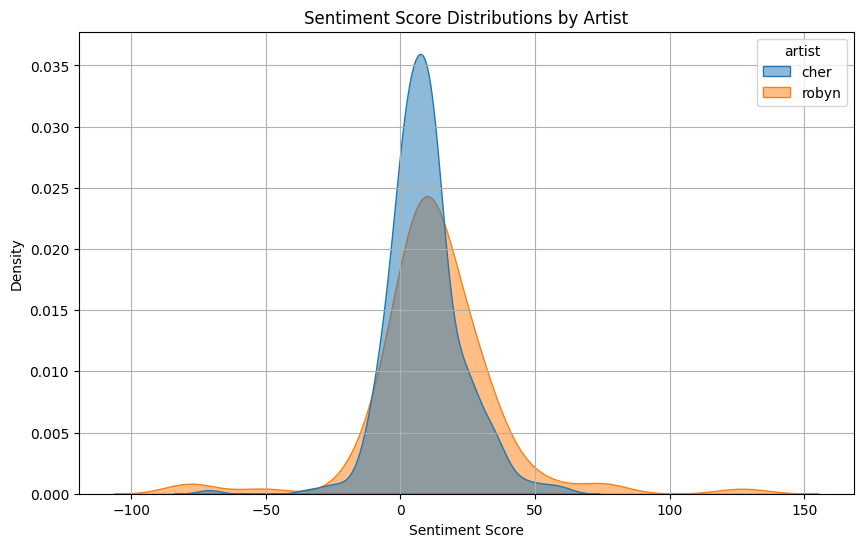

In [58]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_scores, x="sentiment_score", hue="artist", fill=True, common_norm=False, alpha=0.5)
plt.title("Sentiment Score Distributions by Artist")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.grid(True)
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/).

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [59]:
# your code here

positive_emojis = {
    "😊", "😂", "❤️", "😍", "😁", "🥰", "😎", "✨", "👍", "🎉", "😄", "🙌"
}

negative_emojis = {
    "😢", "😠", "💔", "😡", "😭", "😞", "😩", "😤", "👎", "🤬", "😖", "☹️"
}

# Create emoji sentiment dictionary
emoji_sentiment = {emoji: 1 for emoji in positive_emojis}
emoji_sentiment.update({emoji: -1 for emoji in negative_emojis})

In [60]:
artist_emoji_sentiment = {}

for artist, descriptions in twitter_descriptions.items():
    total_score = 0
    total_followers = len(descriptions)

    for desc in descriptions:
        for char in desc:
            total_score += emoji_sentiment.get(char, 0)

    average_score = total_score / total_followers if total_followers > 0 else 0
    artist_emoji_sentiment[artist] = average_score

In [61]:
for artist, avg in artist_emoji_sentiment.items():
    print(f"{artist}: Average Emoji Sentiment = {avg:.2f}")

robynkonichiwa: Average Emoji Sentiment = 0.02
cher: Average Emoji Sentiment = 0.03


Q: What is the average sentiment of your two artists?

A: See above cell output

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji?

A: See below cell output



In [64]:
emoji_counts_by_artist = {}

for artist, descriptions in twitter_descriptions.items():
    all_text = "".join(descriptions)
    emoji_counts = Counter(char for char in all_text if char in emoji_sentiment)
    emoji_counts_by_artist[artist] = emoji_counts

# Step 2: Identify top positive and negative emojis
for artist, counts in emoji_counts_by_artist.items():
    # Separate by sentiment
    positive_only = {e: c for e, c in counts.items() if emoji_sentiment[e] == 1}
    negative_only = {e: c for e, c in counts.items() if emoji_sentiment[e] == -1}

    most_pos = max(positive_only.items(), key=lambda x: x[1], default=("None", 0))
    most_neg = max(negative_only.items(), key=lambda x: x[1], default=("None", 0))

    print(f"\n{artist}")
    print(f"Most popular positive emoji: {most_pos[0]} (used {most_pos[1]} times)")
    print(f"Most popular negative emoji: {most_neg[0]} (used {most_neg[1]} times)")



robynkonichiwa
Most popular positive emoji: ✨ (used 2240 times)
Most popular negative emoji: 💔 (used 60 times)

cher
Most popular positive emoji: ✨ (used 29776 times)
Most popular negative emoji: 💔 (used 1616 times)
